# Not Rabbit Holes

This notebook will be used to do some small analyses throughout the project. 

## 1. Apply Hampel Filter Twice?

This code checks whether applying the Hampel filter on the beat-to-beat difference in heart rate during a ride results in more rows being filtered out than what is filtered out by simply applying it to the heart rates every second.

In [18]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer

from opendata import OpenData

od = OpenData()

In [19]:
# Choosing a test sample. I will use an athlete's activity that I know has no missing data.

athlete = od.get_local_athlete("7780d1e6-26b2-411e-971f-8d35c56e65d8")
activities = list(athlete.activities())
activity = activities[0]

In [20]:
# Creating a pandas dataframe, adding hr as a column, and calculating the difference between consecutive heart rates
df = activity.data.copy()[["secs", "hr"]]

# Applying the Hampel filter to the raw heart rate data. This returns boolean values (outliers = True, inliers = false).
df["hr_filt_bool"] = HampelFilter(window_length=5, return_bool=True).fit_transform(
    df["hr"]
)

# Applying the Hampel filter to the raw heart rate data. This returns filtered values.
df["hr_filt"] = HampelFilter(window_length=5).fit_transform(df["hr"])

# Using linear interpolation to impute NaN values from the filtered heart rate data.
df["hr_filt_imputed"] = Imputer(method="linear").fit_transform(df["hr_filt"])

# Calculating second by second difference in filtered-imputed heart rate
df["hr_filt_imputed_diff"] = df["hr_filt_imputed"].diff()

# Applying hampel filter to the second by second difference in filtered and imputed heart rate data. This returns boolean values (outliers = True, inliers = false).
df["hr_filt_2_bool"] = HampelFilter(window_length=5, return_bool=True).fit_transform(
    df["hr_filt_imputed_diff"]
)

# Applying this boolean series to hr_filt_imputed to get hr_filt_2.
df["hr_filt_2"] = df["hr_filt_imputed"][~df["hr_filt_2_bool"]]

# Using linear interpolation to impute NaN values from the filterd heart rate data in hr_filt_2.
df["hr_filt_2_imputed"] = Imputer(method="linear").fit_transform(df["hr_filt_2"])

c:\Users\karka\miniconda3\envs\golden-cheetah\Lib\site-packages\sktime\transformations\series\outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   secs                  5149 non-null   int64  
 1   hr                    5149 non-null   int64  
 2   hr_filt_bool          5149 non-null   bool   
 3   hr_filt               4812 non-null   float64
 4   hr_filt_imputed       5149 non-null   float64
 5   hr_filt_imputed_diff  5148 non-null   float64
 6   hr_filt_2_bool        5149 non-null   bool   
 7   hr_filt_2             4300 non-null   float64
 8   hr_filt_2_imputed     5149 non-null   float64
dtypes: bool(2), float64(5), int64(2)
memory usage: 291.8 KB


In [ ]:
df.head()

,secs,hr,hr_filt_bool,hr_filt,hr_filt_imputed,hr_filt_imputed_diff,hr_filt_2_bool,hr_filt_2,hr_filt_2_imputed
0,0,104,False,104.0,104.0,NaN,True,NaN,104.0
1,1,104,False,104.0,104.0,0.0,False,104.0,104.0
2,2,104,False,104.0,104.0,0.0,False,104.0,104.0
3,3,104,False,104.0,104.0,0.0,False,104.0,104.0
4,4,105,False,105.0,105.0,1.0,True,NaN,104.5


In [ ]:
# Checking whether the two boolean arrays are the same.
print((df["hr_filt_bool"] == df["hr_filt_2_bool"]).all())

# Counting the number of differences between the two boolean arrays.
int((df["hr_filt_bool"] != df["hr_filt_2_bool"]).sum())

False


1182

The two boolean arrays, *hr_filt_bool* and *hr_filt_2_bool* are not identical. This indicates that applying the hampel filter twice, the first time on the raw heart rate values and again on their row-wise difference (after imputing), results in more values being filtered out. Next, I will plot the original heart rate series against the single filtered and doubly filtered heart rate series for a visual understanding of what is happening. 

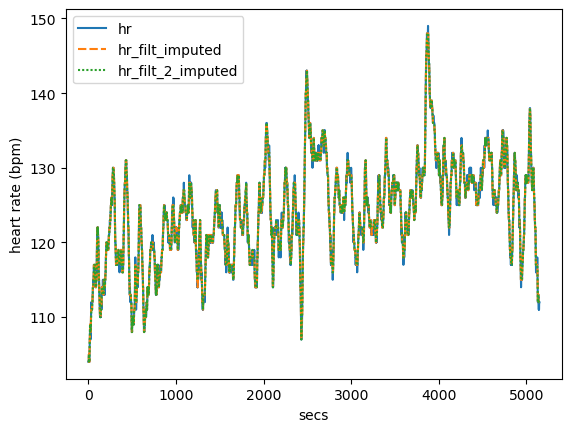

In [ ]:
# Plotting hr, hr_filt_imputed, and hr_filt_2_imputed on a seaborn lineplot.
df_plot = df[["secs", "hr", "hr_filt_imputed", "hr_filt_2_imputed"]]
df_plot.set_index("secs", inplace=True)

fig = sns.lineplot(data=df_plot)
fig.set_xlabel("secs")
fig.set_ylabel("heart rate (bpm)")
plt.show()


In [ ]:
# Creating a plotly.express plot to look for differences between the three series.
fig = px.line(data_frame=df_plot)
fig.show()
fig.write_html(r"..\data\interim\single_v_multiple_filtering.html")

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\interim\\single_v_multiple_filtering.html'

# 2. 4-min Windows for Critical Power Calculation?
This section aims to identify the frequency of 4-min windows that can be used for critical power calculation in the shortlisted athletes. Specifically, we are interested in knowing the percentage of weeks during which an athlete has at least one window.

In [ ]:
# Changing the working directory to the parent directory.
import os

os.chdir("..")

In [19]:
# Importing libraries
import polars as pl
from src.data import Athlete
from rust_utils import hampel_filter
from joblib import Parallel, delayed

In [20]:
# Loading the dataframe containing the shortlisted athletes' data.
df = pl.read_csv(r"data\processed\df_athletes_final_with_hr.csv")

In [ ]:
# Calculating maximal mean power for each athlete
hr_threshold = 0.80
window_len = 4


def processor(row):
    athlete = Athlete(row["id"])
    athlete.max_hr = row["max_hr"]
    df_result = athlete.process_MaxMeanPower(hr_threshold, window_len)
    if df_result.is_empty():
        return pl.DataFrame()
    else:
        return df_result


output_list = Parallel(n_jobs=-1)(
    delayed(processor)(row) for row in df.iter_rows(named=True)
)

output_list = [result for result in output_list if not result.is_empty()]
output_df = pl.concat(output_list)

In [ ]:
output_df

athlete_id,activity_id,date,window_start_seconds,window_end_seconds,maximal_mean_power
str,str,str,i64,i64,f64
"""75119381-8969-4cfe-8c31-f21ce0…","""2019_04_20_08_38_38.csv""","""2019/04/20 12:38:38 UTC""",1148,1388,249.773648
"""75119381-8969-4cfe-8c31-f21ce0…","""2019_04_30_17_06_42.csv""","""2019/04/30 21:06:42 UTC""",950,1190,236.116696
"""75119381-8969-4cfe-8c31-f21ce0…","""2019_05_04_08_47_41.csv""","""2019/05/04 12:47:41 UTC""",1760,2000,228.415408
"""75119381-8969-4cfe-8c31-f21ce0…","""2019_05_06_16_23_37.csv""","""2019/05/06 20:23:37 UTC""",2720,2960,230.068304
"""75119381-8969-4cfe-8c31-f21ce0…","""2019_05_12_18_50_33.csv""","""2019/05/12 22:50:33 UTC""",1220,1460,256.8125
…,…,…,…,…,…
"""f505b200-6daf-46ad-b49e-14ff8e…","""2019_12_10_19_00_29.csv""","""2019/12/10 19:00:29 UTC""",3005,3245,188.354167
"""f505b200-6daf-46ad-b49e-14ff8e…","""2019_12_18_19_10_12.csv""","""2019/12/18 19:10:12 UTC""",1550,1790,179.070833
"""f505b200-6daf-46ad-b49e-14ff8e…","""2020_02_09_12_10_48.csv""","""2020/02/09 12:10:48 UTC""",3287,3527,178.4125


In [ ]:
output_df.write_csv(r"data\interim\4_min_maximal_mean_power_80.csv")

In [18]:
# COUNTING THE PERCENTAGE OF WEEKS ACTIVE THAT AN ATHLETE HAS AT LEAST ONE MAXIMAL MEAN POWER READING

# Loading data
df = pl.read_csv(r"data\processed\df_mmp.csv")
df_athletes_final = pl.read_csv(r"data\processed\df_athletes_final_with_hr.csv")

# Converting date column from string to datetime
df = df.with_columns(pl.col("date").str.strptime(pl.Datetime, r"%Y-%m-%dT%H:%M:%S%.f"))

# Sorting the dataframe by athlete_id and date
df = df.sort(["athlete_id", "date"], descending=[False, False])

# Creating an empty dataframe to store the results
output_df = pl.DataFrame()

# Looping through each athlete in the dataframe
for athlete_id in df.select(pl.col("athlete_id").unique()).to_series():
    # Filtering the dataframe for the current athlete
    df_athlete = df.filter(pl.col("athlete_id") == athlete_id)

    # Getting the athlete's duration active on Golden Cheetah from df_athletes_final
    days_bw_first_and_last_readings = (
        df_athlete.select(pl.col("date")).tail(1).item()
        - df_athlete.select(pl.col("date")).head(1).item()
    ).days
    duration_active_in_weeks = days_bw_first_and_last_readings // 7 + 1

    # Creating a new column called week_number that contains the week number for the date counted from the first maximal mean power reading for the athlete
    date_of_first_reading = df_athlete.select(pl.col("date"))[0].item()
    df_athlete = df_athlete.with_columns(
        ((pl.col("date") - date_of_first_reading).dt.total_days() // 7).alias(
            "week_number"
        )
    )

    # Counting the number of unique weeks in which the athlete has at least one maximal mean power reading
    weeks_with_readings = df_athlete.select(
        pl.col("week_number").unique().count()
    ).item()

    # Calculating the percentage of weeks active for which the athlete has at least one maximal mean power reading
    percentage_weeks_with_readings = (
        weeks_with_readings / duration_active_in_weeks * 100
    )

    # Adding the results to the output dataframe
    output_df = pl.concat(
        [
            output_df,
            pl.DataFrame(
                {
                    "athlete_id": athlete_id,
                    "weeks_with_readings": weeks_with_readings,
                    "weeks_between_first_and_last_readings": duration_active_in_weeks,
                    "percentage_weeks_with_readings": float(
                        percentage_weeks_with_readings
                    ),
                }
            ),
        ]
    )

In [19]:
df.head()

athlete_id,activity_id,date,week_no,mmp_window_start_secs,mmp_window_end_secs,maximal_mean_power
str,str,datetime[μs],i64,i64,i64,f64
"""01843f3a-8883-4a76-a60f-223c92…","""2018_05_18_13_18_17.csv""",2018-05-18 20:18:17,45,572,812,204.208333
"""01843f3a-8883-4a76-a60f-223c92…","""2018_05_18_13_32_00.csv""",2018-05-18 20:32:00,45,7,247,277.9
"""01843f3a-8883-4a76-a60f-223c92…","""2018_05_20_08_08_27.csv""",2018-05-20 14:08:27,45,9224,9464,232.133333
"""01843f3a-8883-4a76-a60f-223c92…","""2018_05_23_11_18_03.csv""",2018-05-23 17:18:03,46,3370,3610,245.025
"""01843f3a-8883-4a76-a60f-223c92…","""2018_05_23_11_18_03.csv""",2018-05-23 17:18:03,46,7065,7305,209.279167


In [24]:
output_df.sort("percentage_weeks_with_readings", descending=True)

athlete_id,weeks_with_readings,weeks_between_first_and_last_readings,percentage_weeks_with_readings
str,i64,i64,f64
"""95c29407-3898-46d9-9399-53ca39…",19,19,100.0
"""4a07f9c7-58d7-413d-8e7b-ca3c5f…",1,1,100.0
"""01843f3a-8883-4a76-a60f-223c92…",2,2,100.0
"""d222716f-5ed8-46f9-a35c-ec6b3d…",56,56,100.0
"""dd2eee24-b271-4cbd-be01-66b804…",71,71,100.0
…,…,…,…
"""afaf9967-adcd-4e9b-b117-55ca70…",7,13,53.846154
"""fe4bcccf-399f-4cd4-b385-e3b053…",36,67,53.731343
"""06f81197-504a-478b-a347-052d4d…",112,362,30.939227


In [25]:
output_df.sort("percentage_weeks_with_readings", descending=True).write_csv(
    r"data\interim\4_min_at_80_summary.csv"
)

# 3. Merging MMP and HRR

In this section, I will apply the MMP and HRR functions to all 41 athletes and save the resulting dataframes.

In [1]:
# RUN CELL ONLY ONCE FOR EACH RESTART
# Changing the working directory to the parent directory.
import os

os.chdir("..")

In [54]:
# Imports
import polars as pl
from src.data import Athlete
from joblib import Parallel, delayed

In [24]:
# Loading the dataframe containing the athletes' data
df = pl.read_csv(r"data\processed\df_athletes_final_with_hr.csv")

In [55]:
# Defining a processor function for parallel processing

# Defining constants
hr_threshold = 0.85
window_len = 4


def processor(row):
    athlete = Athlete(row["id"])
    athlete.max_hr = row["max_hr"]

    df_hrr = athlete.process_hrr()
    df_mmp = athlete.process_mmp(hr_threshold, window_len)

    return [df_hrr, df_mmp]

In [56]:
# Running the processor function in parallel for each athlete
output_list = Parallel(n_jobs=-1)(
    delayed(processor)(row) for row in df.iter_rows(named=True)
)

# Concatenating the results
output_hrr = pl.concat([result[0] for result in output_list])
output_mmp = pl.concat([result[1] for result in output_list])

In [58]:
output_hrr

athlete_id,gender,week_no,activity_id,date,hrr_window_start_secs,hrr_window_end_secs,HRR(30)
str,str,i64,str,datetime[μs],i64,i64,i64
"""3a74749c-d364-465a-8b26-47a6a5…","""M""",7,"""2019_10_05_06_01_37.csv""",2019-10-05 04:01:37,2635,2664,17
"""3a74749c-d364-465a-8b26-47a6a5…","""M""",7,"""2019_10_05_06_01_37.csv""",2019-10-05 04:01:37,10305,10334,21
"""3a74749c-d364-465a-8b26-47a6a5…","""M""",9,"""2019_10_19_06_04_04.csv""",2019-10-19 04:04:04,595,624,30
"""3a74749c-d364-465a-8b26-47a6a5…","""M""",10,"""2019_10_26_06_01_20.csv""",2019-10-26 04:01:20,10786,10815,18
"""3a74749c-d364-465a-8b26-47a6a5…","""M""",12,"""2019_11_09_05_57_57.csv""",2019-11-09 03:57:57,2734,2763,36
…,…,…,…,…,…,…,…
"""f3771ea1-af65-4b36-90ad-6ffb5a…","""F""",180,"""2020_02_12_14_03_54.csv""",2020-02-12 13:03:54,7135,7164,36
"""f3771ea1-af65-4b36-90ad-6ffb5a…","""F""",182,"""2020_02_25_09_08_21.csv""",2020-02-25 08:08:21,1911,1940,38
"""f3771ea1-af65-4b36-90ad-6ffb5a…","""F""",183,"""2020_03_04_14_10_13.csv""",2020-03-04 13:10:13,8767,8796,23


In [60]:
output_mmp

athlete_id,gender,week_no,activity_id,date,mmp_window_start_secs,mmp_window_end_secs,maximal_mean_power
str,str,i64,str,datetime[μs],i64,i64,f64
"""75119381-8969-4cfe-8c31-f21ce0…","""M""",2,"""2019_05_04_08_47_41.csv""",2019-05-04 12:47:41,1775,2015,224.013704
"""75119381-8969-4cfe-8c31-f21ce0…","""M""",2,"""2019_05_06_16_23_37.csv""",2019-05-06 20:23:37,2720,2960,230.068304
"""75119381-8969-4cfe-8c31-f21ce0…","""M""",5,"""2019_05_29_08_25_43.csv""",2019-05-29 12:25:43,2541,2781,164.306096
"""75119381-8969-4cfe-8c31-f21ce0…","""M""",15,"""2019_08_09_08_22_27.csv""",2019-08-09 12:22:27,11938,12178,170.506401
"""75119381-8969-4cfe-8c31-f21ce0…","""M""",32,"""2019_11_29_09_17_02.csv""",2019-11-29 14:17:02,218,458,265.220833
…,…,…,…,…,…,…,…
"""f505b200-6daf-46ad-b49e-14ff8e…","""F""",43,"""2019_10_16_19_13_38.csv""",2019-10-16 18:13:38,1958,2198,200.0375
"""f505b200-6daf-46ad-b49e-14ff8e…","""F""",44,"""2019_10_22_19_07_36.csv""",2019-10-22 18:07:36,1696,1936,195.575
"""f505b200-6daf-46ad-b49e-14ff8e…","""F""",44,"""2019_10_24_18_35_29.csv""",2019-10-24 17:35:29,1947,2187,185.908333


In [27]:
output_hrr.write_csv(r"data\processed\df_hrr.csv")
output_mmp.write_csv(r"data\processed\df_mmp.csv")

In [ ]:
df_merged = output_hrr.join(
    output_mmp, on=["athlete_id", "gender", "week_no"], how="inner"
)

In [ ]:
from opendata import OpenData

od = OpenData()
athlete = od.get_local_athlete("5d832f19-7169-409f-b1d3-6947b72e423b")
activity = athlete.get_activity("2018_06_24_09_00_07.csv")

In [29]:
df_merged.write_csv(r"data\interim\df_hrr_mmp_merged.csv")

In [4]:
df = pl.read_csv(r"data\interim\df_hrr_mmp_merged.csv")

In [5]:
df.group_by("athlete_id").agg(
    pl.col("week_no").unique().count().alias("weeks_with_readings")
).sort("weeks_with_readings", descending=True).head(1)["athlete_id"][0]

'42c28be1-0f23-4e72-99be-adce9a593411'

In [ ]:
test_df = (
    df.filter(pl.col("athlete_id") == "42c28be1-0f23-4e72-99be-adce9a593411")
    .sort(["week_no", "HRR(30)", "maximal_mean_power"], descending=[False, True, True])
    .group_by("week_no", maintain_order=True)
    .head(1)
)

In [7]:
test_df

week_no,athlete_id,activity_id,date,hrr_window_start_secs,hrr_window_end_secs,HRR(30),activity_id_right,date_right,mmp_window_start_secs,mmp_window_end_secs,maximal_mean_power
i64,str,str,str,i64,i64,i64,str,str,i64,i64,f64
5,"""42c28be1-0f23-4e72-99be-adce9a…","""2015_12_27_12_05_41.csv""","""2015-12-27T11:05:41.000000""",9152,9181,34,"""2015_12_25_10_41_01.csv""","""2015-12-25T09:41:01.000000""",1172,1412,232.0875
15,"""42c28be1-0f23-4e72-99be-adce9a…","""2016_03_05_09_09_45.csv""","""2016-03-05T08:09:45.000000""",7356,7385,36,"""2016_03_05_09_09_45.csv""","""2016-03-05T08:09:45.000000""",14246,14486,206.5625
16,"""42c28be1-0f23-4e72-99be-adce9a…","""2016_03_12_09_10_06.csv""","""2016-03-12T08:10:06.000000""",3457,3486,35,"""2016_03_09_21_24_30.csv""","""2016-03-09T20:24:30.000000""",2745,2985,268.3125
18,"""42c28be1-0f23-4e72-99be-adce9a…","""2016_03_26_13_19_41.csv""","""2016-03-26T12:19:41.000000""",8764,8793,29,"""2016_03_22_22_15_44.csv""","""2016-03-22T21:15:44.000000""",1233,1473,258.629167
20,"""42c28be1-0f23-4e72-99be-adce9a…","""2016_04_09_15_25_05.csv""","""2016-04-09T13:25:05.000000""",3455,3484,33,"""2016_04_09_15_25_05.csv""","""2016-04-09T13:25:05.000000""",1163,1403,234.879167
…,…,…,…,…,…,…,…,…,…,…,…
165,"""42c28be1-0f23-4e72-99be-adce9a…","""2019_01_16_21_04_54.csv""","""2019-01-16T20:04:54.000000""",3238,3267,23,"""2019_01_16_21_04_54.csv""","""2019-01-16T20:04:54.000000""",2527,2767,264.741667
166,"""42c28be1-0f23-4e72-99be-adce9a…","""2019_01_24_13_25_54.csv""","""2019-01-24T12:25:54.000000""",3874,3903,22,"""2019_01_24_13_25_54.csv""","""2019-01-24T12:25:54.000000""",2924,3164,267.495833
167,"""42c28be1-0f23-4e72-99be-adce9a…","""2019_01_31_14_20_42.csv""","""2019-01-31T13:20:42.000000""",3641,3670,34,"""2019_01_29_21_19_37.csv""","""2019-01-29T20:19:37.000000""",317,557,297.020833


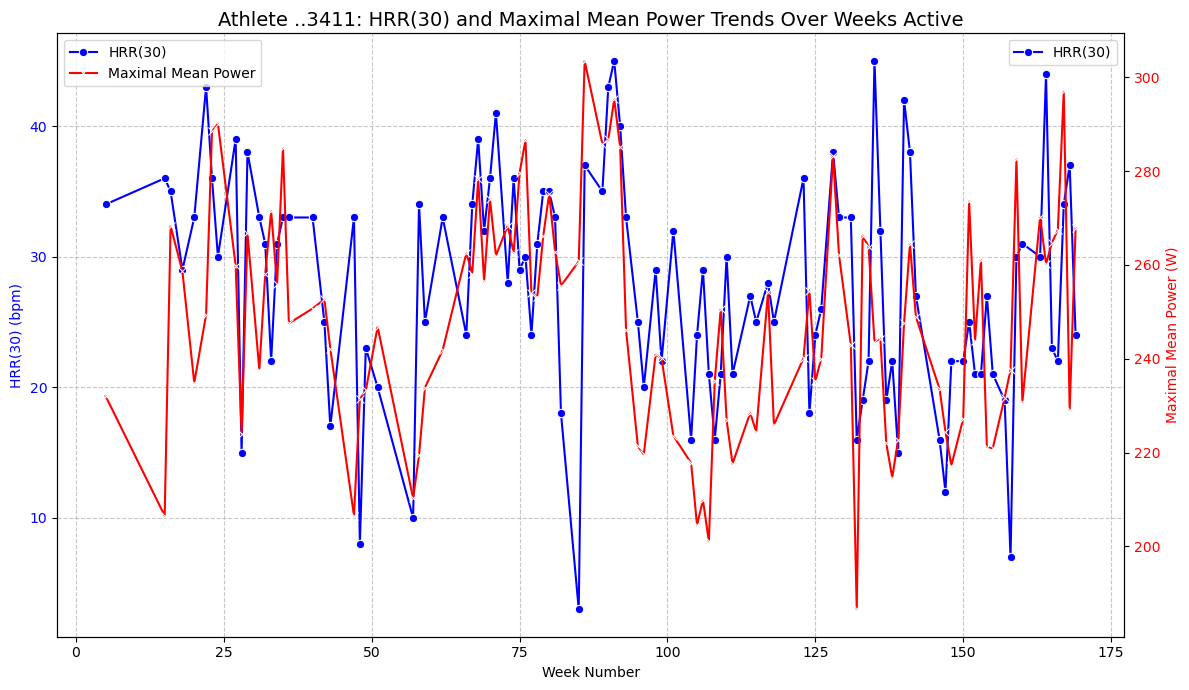

In [ ]:
import seaborn as sns

test_df_pandas = test_df.to_pandas()

# Plotting with a Secondary Y-axis
fig, ax1 = plt.subplots(figsize=(12, 7))  # Create a figure and a primary axes

# Plot HRR(30) on the primary y-axis (ax1)
sns.lineplot(
    data=test_df_pandas,
    x="week_no",
    y="HRR(30)",
    ax=ax1,
    color="blue",
    marker="o",
    label="HRR(30)",
)
ax1.set_xlabel("Week Number")
ax1.set_ylabel("HRR(30) (bpm)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True, linestyle="--", alpha=0.7)

# Create a secondary y-axis (ax2) that shares the same x-axis
ax2 = ax1.twinx()
# Plot maximal_mean_power on the secondary y-axis (ax2)
sns.lineplot(
    data=test_df_pandas,
    x="week_no",
    y="maximal_mean_power",
    ax=ax2,
    color="red",
    marker="x",
    label="Maximal Mean Power",
)
ax2.set_ylabel("Maximal Mean Power (W)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add a title
plt.title(
    "Athlete ..3411: HRR(30) and Maximal Mean Power Trends Over Weeks Active",
    fontsize=14,
)

# Add a legend for both lines
# Combined legend using handles and labels from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [28]:
df = pl.read_csv(r"data\processed\df_hrr.csv")
df.sort(by="HRR(30)", descending=True)

athlete_id,activity_id,date,week_no,hrr_window_start_secs,hrr_window_end_secs,HRR(30)
str,str,str,i64,i64,i64,i64
"""5d832f19-7169-409f-b1d3-6947b7…","""2018_06_24_09_00_07.csv""","""2018-06-24T07:00:07.000000""",15,4592,4621,148
"""5d832f19-7169-409f-b1d3-6947b7…","""2018_06_24_09_00_07.csv""","""2018-06-24T07:00:07.000000""",15,5698,5727,139
"""da6ab7ad-655c-4e4b-ac95-7af4cd…","""2019_07_28_10_48_15.csv""","""2019-07-28T08:48:15.000000""",81,11081,11110,96
"""bce0f962-41e6-4d36-a5f0-e12f64…","""2018_03_03_09_18_52.csv""","""2018-03-03T01:18:52.000000""",106,1615,1644,68
"""df6f2e29-5e82-431d-8549-27ca0f…","""2017_05_14_08_54_03.csv""","""2017-05-14T06:54:03.000000""",37,4124,4153,65
…,…,…,…,…,…,…
"""df6f2e29-5e82-431d-8549-27ca0f…","""2018_03_18_09_56_30.csv""","""2018-03-18T08:56:30.000000""",82,10609,10638,0
"""df6f2e29-5e82-431d-8549-27ca0f…","""2018_05_06_10_00_03.csv""","""2018-05-06T08:00:03.000000""",88,9188,9217,0
"""df6f2e29-5e82-431d-8549-27ca0f…","""2018_05_13_10_38_21.csv""","""2018-05-13T08:38:21.000000""",90,3528,3557,0


# 4. Updating HRR
Updating the HRR function resulted in a sharp decline in readings. I will check whether this might be because of incorrect HR_max readings. I will set my HR_max to be the median of the largest readings across all rides after filtering.

In [1]:
import os

os.chdir(r"..")

In [2]:
import polars as pl
import numpy as np
from joblib import Parallel, delayed
from src.data import Athlete
from rust_utils import hampel_filter

In [5]:
df = pl.read_csv(r"data\processed\df_athletes_final_with_hr.csv")

In [ ]:
def processor(row):
    athlete = Athlete(row["id"])
    athlete.get_hr_min_max()
    df_temp = pl.DataFrame(
        {
            "athlete_id": [athlete.id],
            "hr_min": [athlete.min_hr],
            "hr_max": [athlete.max_hr],
        }
    )
    return df_temp

In [15]:
row = next(df.iter_rows(named=True))
processor(row)

Athlete data loaded successfully from local storage.
Minimum heart rate for athlete 75119381-8969-4cfe-8c31-f21ce0f7ae3a is 80.0 bpm.
Maximum heart rate for athlete 75119381-8969-4cfe-8c31-f21ce0f7ae3a is 161.0 bpm.


athlete_id,hr_min,hr_max
str,f64,f64
"""75119381-8969-4cfe-8c31-f21ce0…",80.0,161.0


In [34]:
output_list = Parallel(n_jobs=-1)(
    delayed(processor)(row) for row in df.iter_rows(named=True)
)

In [77]:
output_df = pl.concat(output_list)

TypeError: did not expect type: 'list' in `concat`

In [76]:
pl.Config.set_tbl_rows(45)
output_df.sort(by="hr_min")

athlete_id,hr_min,hr_max
str,f64,f64
"""f505b200-6daf-46ad-b49e-14ff8e…",57.0,160.0
"""acd66fb1-e8e9-4a83-8269-939b54…",64.0,176.0
"""fe4bcccf-399f-4cd4-b385-e3b053…",66.0,159.0
"""4a07f9c7-58d7-413d-8e7b-ca3c5f…",69.5,165.0
"""a1b0ba71-e335-4fd9-8f9a-cc7b5a…",75.0,173.0
"""366f2948-6a84-46ec-9306-947844…",76.0,172.0
"""e58c276d-9e21-4dcf-8121-703ee2…",76.0,159.0
"""95c29407-3898-46d9-9399-53ca39…",77.0,165.0
"""433abcb7-e4db-4002-892b-f033db…",77.0,174.0


In [3]:
df = pl.read_csv(r"data\interim\hr_min_max_by_median.csv")

In [10]:
# Defining a processor function for parallel processing

# Defining constants
hr_threshold = 0.9
window_len = 4


def processor(row):
    athlete = Athlete(row["athlete_id"])
    athlete.max_hr = row["hr_max"]

    df_hrr = athlete.process_hrr()
    df_mmp = athlete.process_mmp(hr_threshold, window_len)

    return [df_hrr, df_mmp]

In [11]:
# Running the processor function in parallel for each athlete
output_list = Parallel(n_jobs=-1)(
    delayed(processor)(row) for row in df.iter_rows(named=True)
)

# Concatenating the results
output_hrr = pl.concat([result[0] for result in output_list])
output_mmp = pl.concat([result[1] for result in output_list])

In [ ]:
df_merged = output_hrr.join(
    other=output_mmp, on=["athlete_id", "gender", "week_no"], how="inner"
)

In [ ]:
no_males = (
    df_merged.group_by("athlete_id").first().filter(pl.col("gender") == "M").height
)

no_females = (
    df_merged.group_by("athlete_id").first().filter(pl.col("gender") == "F").height
)

print(no_males, no_females)

20 18
